In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
/kaggle/input/emotion-classification-nlp/emotion-labels-train.csv
/kaggle/input/emotion-classification-nlp/emotion-labels-val.csv
/kaggle/input/emotion-classification-nlp/emotion-labels-test.csv


**If you find this notebook useful, please consider up-voting. I would really appreciate it. Have a nice day!**

In [2]:
# Reading data sets
df1 = pd.read_csv("/kaggle/input/emotion-classification-nlp/emotion-labels-train.csv")
df2 = pd.read_csv("/kaggle/input/emotion-classification-nlp/emotion-labels-test.csv")
df3 = pd.read_csv("/kaggle/input/emotion-classification-nlp/emotion-labels-val.csv")

In [3]:
# Info about all three data sets
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3613 entries, 0 to 3612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3613 non-null   object
 1   label   3613 non-null   object
dtypes: object(2)
memory usage: 56.6+ KB


In [4]:
# Info about all three data sets
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3142 non-null   object
 1   label   3142 non-null   object
dtypes: object(2)
memory usage: 49.2+ KB


In [5]:
# Info about all three data sets
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    347 non-null    object
 1   label   347 non-null    object
dtypes: object(2)
memory usage: 5.5+ KB


In [6]:
# Checking whether there are NULL values

print("Number of NULL values in the training set: ")
print(df1.isnull().sum())
print("Number of NULL values in the test set: ")
print(df2.isnull().sum())
print("Number of NULL values in the validation set: ")
print(df3.isnull().sum())

Number of NULL values in the training set: 
text     0
label    0
dtype: int64
Number of NULL values in the test set: 
text     0
label    0
dtype: int64
Number of NULL values in the validation set: 
text     0
label    0
dtype: int64


In [7]:
# Deleting possible duplicates

df1.drop(df1[df1.duplicated()].index, axis=0, inplace=True)
df2.drop(df2[df2.duplicated()].index, axis=0, inplace=True)
df3.drop(df3[df3.duplicated()].index, axis=0, inplace=True)

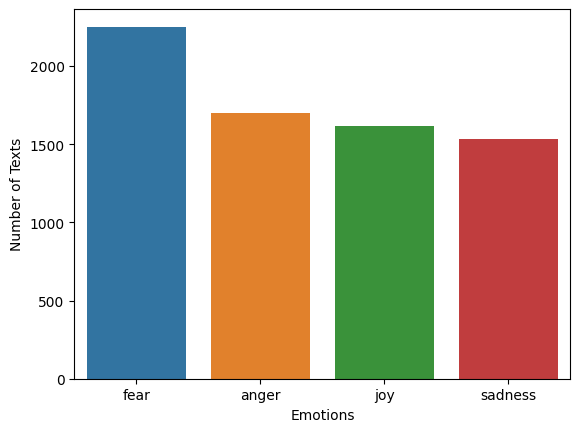

In [8]:
# Concatenating DFs for a better visualisation
combined_df = pd.concat([df1, df2, df3])
label_counts = combined_df['label'].value_counts()

# Countplot
sns.countplot(x='label', data=combined_df, order=combined_df['label'].value_counts().index)
plt.xlabel('Emotions')
plt.ylabel('Number of Texts')
plt.show()

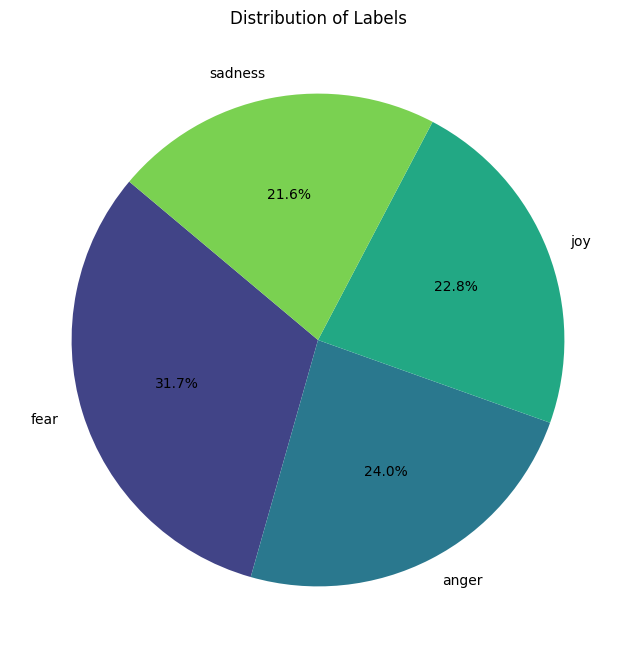

In [9]:
# A piechart for understanding the proportion
plt.figure(figsize=(8, 8))
plt.pie(combined_df['label'].value_counts().values, labels=combined_df['label'].value_counts().index, autopct='%1.1f%%', startangle=140, 
        colors=sns.color_palette('viridis', len(combined_df['label'].value_counts().index)))
plt.title('Distribution of Labels')
plt.show()

In [10]:
# Making text lowercase
df1['text']= df1['text'].apply(lambda x: x.lower())
df2['text']= df2['text'].apply(lambda x: x.lower())
df3['text']= df3['text'].apply(lambda x: x.lower())

In [11]:
# Defining a function removing stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Defining a lemmatisation function
def apply_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Defining a tokenisation function
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Defining a function for token lemmatisation
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

In [12]:
def parse_emojis(text):
    # Extract all emojis from the text
    emojis = [c for c in text if c in emoji.distinct_emoji_list(c)]

    # Convert emojis to their names
    emoji_names = [emoji.demojize(e) for e in emojis]

    # Join the emoji names into a single string
    parsed_emojis = ' '.join(emoji_names)

    return parsed_emojis

def remove_special_characters(text):
    # Removing mentions (including the username or handle) and words coming after them
    text = re.sub(r'@\w+', '', text)
    
    # Removing hashtags and replacing with ','
    text = re.sub(r'#', ',', text)
    
    # Parsing emojis
    text = str(parse_emojis(text))
    
    # Removing numbers
    text = re.sub(r'\d+', '', text)

    # Removing HTML tags
    text = re.sub(r'<[^>]*>', '', text)
    
    # Removing URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    return text

In [13]:
df1['text'] = df1['text'].apply(remove_special_characters)
df2['text'] = df2['text'].apply(remove_special_characters)
df3['text'] = df3['text'].apply(remove_special_characters)

In [14]:
df1['text'] = df1['text'].apply(remove_stopwords)
df2['text'] = df2['text'].apply(remove_stopwords)
df3['text'] = df3['text'].apply(remove_stopwords)

In [15]:
# Defining a function to apply label encoding to non-numeric columns in a DataFrame
def label_encode_dataframe(df):
    # Identify non-numeric columns
    non_numeric_cols = df.select_dtypes(exclude=[int, float]).columns

    # Apply label encoding to non-numeric columns
    # Iterate over the non-numeric columns
    for col in non_numeric_cols:
        label_encoder = LabelEncoder()  # Create a label encoder for each column
        df[col] = label_encoder.fit_transform(df[col])  # Apply label encoding to the column

    return df

df_num1 = label_encode_dataframe(df1)
df_num2 = label_encode_dataframe(df2)
df_num3 = label_encode_dataframe(df3)

In [16]:
X_train = df_num1["text"]
Y_train = df_num1['label']

X_test = df_num2["text"]
Y_test = df_num2['label']

X_val = df_num3["text"]
Y_val = df_num3['label']

In [17]:
scaler = MinMaxScaler()

# Reshape the selected column into a 2D array
X_train_scaled = scaler.fit_transform(X_train.values.reshape(-1, 1))
X_test_scaled = scaler.fit_transform(X_test.values.reshape(-1, 1))
X_val_scaled = scaler.fit_transform(X_val.values.reshape(-1, 1))

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape, X_val.shape, Y_val.shape

((3613,), (3142,), (3613,), (3142,), (347,), (347,))

In [18]:
# Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
random_forest.fit(X_train_scaled, Y_train)

# Predictions on the validation set
Y_val_pred = random_forest.predict(X_val_scaled)

# Evaluate the model on the validation set
acc_random_forest_val = accuracy_score(Y_val, Y_val_pred)
print("Random Forest (Validation): ", round(acc_random_forest_val * 100, 2))

# If you're satisfied with the model's performance on the validation set, you can then evaluate it on the test set
Y_test_pred = random_forest.predict(X_test_scaled)
acc_random_forest_test = accuracy_score(Y_test, Y_test_pred)
print("Random Forest (Test): ", round(acc_random_forest_test * 100, 2))

Random Forest (Validation):  31.41
Random Forest (Test):  31.38


In [19]:
# Gaussian Naive Bayes model
naive_bayes = GaussianNB()

# Train the model on the training set
naive_bayes.fit(X_train_scaled, Y_train)

# Predictions on the validation set
Y_val_pred = naive_bayes.predict(X_val_scaled)

# Evaluate the model on the validation set
acc_naive_bayes_val = accuracy_score(Y_val, Y_val_pred)
print("Gaussian Naive Bayes (Validation): ", round(acc_naive_bayes_val * 100, 2))

# If you're satisfied with the model's performance on the validation set, you can then evaluate it on the test set
Y_test_pred = naive_bayes.predict(X_test_scaled)

# Evaluate the model on the test set
acc_naive_bayes_test = accuracy_score(Y_test, Y_test_pred)
print("Gaussian Naive Bayes (Test): ", round(acc_naive_bayes_test * 100, 2))

Gaussian Naive Bayes (Validation):  31.7
Gaussian Naive Bayes (Test):  31.67


**The accuracy using Random Forest and Gaussian Naive Bayes is too low. Further attempts to increase the accuracy will be made shortly.**